In [1]:
# dependencies
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import pickle
from collections import Counter



In [4]:
# BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
#dataRead


en_sentences = []
es_sentences = []

for i in range(3):
    with open("dataset/europarl-v7.es-en-" + str(i) +".en", 'r') as en_file:
        for en_line in en_file:
            en_sentences.append(en_line)
    print ("read en" + str(i))
    with open("dataset/europarl-v7.es-en-" + str(i) +".es", 'r') as es_file:
        for es_line in es_file:
            es_sentences.append(es_line)
    print ("read es" + str(i))

read en0
read es0
read en1
read es1
read en2
read es2


In [5]:
index = 123
print (en_sentences[index])
print (es_sentences[index])

I regret this, but the vote has already been taken and the decision is made so let us leave the matter there.

Lo lamento, pero la votación se ha realizado, se ha adoptado la decisión y, por consiguiente, dejemos así las cosas.



In [6]:
#DataPreparation
def create_dataset(source_sentences,target_sentences):
    source_vocab_dict = Counter(word.strip(',." ;:)(][?!') for sentence in source_sentences for word in sentence.split())
    target_vocab_dict = Counter(word.strip(',." ;:)(][?!') for sentence in target_sentences for word in sentence.split())

    source_vocab = list(map(lambda x: x[0], sorted(source_vocab_dict.items(), key = lambda x: -x[1])))
    target_vocab = list(map(lambda x: x[0], sorted(target_vocab_dict.items(), key = lambda x: -x[1])))
    
    source_vocab = source_vocab[:20000]
    target_vocab = target_vocab[:30000]
    
    start_idx = 2
    source_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(source_vocab)])
    source_word2idx['<ukn>'] = 0
    source_word2idx['<pad>'] = 1
    source_idx2word = dict([(idx, word) for word, idx in source_word2idx.items()])
    
    start_idx = 4
    target_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(target_vocab)])
    target_word2idx['<ukn>'] = 0
    target_word2idx['<go>']  = 1
    target_word2idx['<eos>'] = 2
    target_word2idx['<pad>'] = 3
    
    target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])
    x = [[source_word2idx.get(word.strip(',." ;:)(][?!'), 0) for word in sentence.split()] for sentence in source_sentences]
    y = [[target_word2idx.get(word.strip(',." ;:)(][?!'), 0) for word in sentence.split()] for sentence in target_sentences]
    
    X = []
    Y = []
    
    for i in range(len(x)):
        n1 = len(x[i])
        n2 = len(y[i])
        n = n1 if n1 < n2 else n2 
        if abs(n1 - n2) <= 0.3 * n:
            if n1 <= 15 and n2 <= 15:
                X.append(x[i])
                Y.append(y[i])
    return X, Y, source_word2idx, source_idx2word, source_vocab, target_word2idx, target_idx2word, target_vocab

def save_dataset(file_path, obj):
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f, -1)

def read_dataset(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [7]:
#en_sentences = ['hello my friend', 'we need to reboot the server']
#es_sentences = ['hola mi amigo', 'necesitamos reiniciar el servidor']
save_dataset('./data.pkl', create_dataset(en_sentences, es_sentences))

In [8]:
# read dataset
X, Y, en_word2idx, en_idx2word, en_vocab, es_word2idx, es_idx2word, es_vocab = read_dataset('data.pkl')

In [9]:
#CHECK THAT WORKs
print ('Sentence in English - encoded:', X[0])
print ('Sentence in Spanish - encoded:', Y[0])
print ('Decoded:\n------------------------')

for i in range(len(X[0])):
    print (en_idx2word[X[0][i]], end = ' ')
    
print('\n')

for i in range(len(Y[0])):
    print (es_idx2word[Y[0][i]], end = ' ')

Sentence in English - encoded: [9207, 3, 2, 1713]
Sentence in Spanish - encoded: [11270, 13, 594, 4, 1490]
Decoded:
------------------------
Resumption of the session 

Reanudación del período de sesiones 

In [10]:
# data processing

# data padding
def data_padding(x, y, length = 15):
    for i in range(len(x)):
        x[i] = x[i] + (length - len(x[i])) * [en_word2idx['<pad>']]
        y[i] = [es_word2idx['<go>']] + y[i] + [es_word2idx['<eos>']] + (length-len(y[i])) * [es_word2idx['<pad>']]

data_padding(X, Y)
#print X

# data splitting
X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

del X
del Y

In [11]:
# build a model

input_seq_len = 15
output_seq_len = 17
en_vocab_size = len(en_vocab) + 2 # + <pad>, <ukn>
es_vocab_size = len(es_vocab) + 4 # + <pad>, <ukn>, <eos>, <go>

# placeholders
encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
# add one more target
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target'))
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], name = 'target_w{}'.format(i)) for i in range(output_seq_len)]

# output projection
size = 512
w_t = tf.get_variable('proj_w', [es_vocab_size, size], tf.float32)
b = tf.get_variable('proj_b', [es_vocab_size], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.contrib.rnn.BasicLSTMCell(size),
                                            num_encoder_symbols = en_vocab_size,
                                            num_decoder_symbols = es_vocab_size,
                                            embedding_size = 100,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

In [12]:
# define our loss function

# sampled softmax loss - returns: A batch_size 1-D tensor of per-example sampled softmax losses
def sampled_loss(labels, logits):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = es_vocab_size)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.contrib.legacy_seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

In [13]:
# let's define some helper functions

# simple softmax function
def softmax(x):
    n = np.max(x)
    e_x = np.exp(x - n)
    return e_x / e_x.sum()

# feed data into placeholders
def feed_dict(x, y, batch_size = 8): #batch size was 64
    feed = {}
    
    idxes = np.random.choice(len(x), size = batch_size, replace = False)
    
    for i in range(input_seq_len):
        feed[encoder_inputs[i].name] = np.array([x[j][i] for j in idxes], dtype = np.int32)
        
    for i in range(output_seq_len):
        feed[decoder_inputs[i].name] = np.array([y[j][i] for j in idxes], dtype = np.int32)
        
    feed[targets[len(targets)-1].name] = np.full(shape = [batch_size], fill_value = es_word2idx['<pad>'], dtype = np.int32)
    
    for i in range(output_seq_len-1):
        batch_weights = np.ones(batch_size, dtype = np.float32)
        target = feed[decoder_inputs[i+1].name]
        for j in range(batch_size):
            if target[j] == es_word2idx['<pad>']:
                batch_weights[j] = 0.0
        feed[target_weights[i].name] = batch_weights
        
    feed[target_weights[output_seq_len-1].name] = np.zeros(batch_size, dtype = np.float32)
    
    return feed

# decode output sequence
def decode_output(output_seq):
    words = []
    for i in range(output_seq_len):
        smax = softmax(output_seq[i])
        idx = np.argmax(smax)
        words.append(es_idx2word[idx])
    return words

In [30]:
# ops and hyperparameters
learning_rate = 5e-3
batch_size = 64 #was64
steps = 50000

# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

# training op
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# init op
init = tf.global_variables_initializer()

# forward step
def forward_step(sess, feed):
    output_sequences = sess.run(outputs_proj, feed_dict = feed)
    return output_sequences

# training step
def backward_step(sess, feed):
    sess.run(optimizer, feed_dict = feed)

In [31]:
# let's train the model

# we will use this list to plot losses through steps
losses = []

# save a checkpoint so we can restore the model later 
saver = tf.train.Saver()

print ('------------------TRAINING------------------')
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    t = time.time()
    for step in range(steps):
        feed = feed_dict(X_train, Y_train)
             
        backward_step(sess, feed)
        
        if step % 5 == 4 or step == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print ('step: {}, loss: {}'.format(step, loss_value))
            losses.append(loss_value)
        
        if step % 20 == 19:
            saver.save(sess, 'checkpoints/', global_step=step)
            print ('Checkpoint is saved')
    training_log = 'Training time for {0} steps: {1}s'.format(steps, time.time() - t)
            
    print (training_log)

------------------TRAINING------------------
step: 0, loss: 8.92647933959961
step: 4, loss: 9.084221839904785
step: 9, loss: 9.157144546508789
step: 14, loss: 8.999015808105469
step: 19, loss: 9.148736953735352
Checkpoint is saved
step: 24, loss: 9.023209571838379
step: 29, loss: 8.990303993225098
step: 34, loss: 8.869390487670898
step: 39, loss: 9.280086517333984
Checkpoint is saved
step: 44, loss: 8.906085014343262
step: 49, loss: 8.867454528808594
step: 54, loss: 8.768623352050781
step: 59, loss: 8.021533012390137
Checkpoint is saved
step: 64, loss: 6.755884170532227
step: 69, loss: 6.796221733093262
step: 74, loss: 6.685888767242432
step: 79, loss: 6.378986835479736
Checkpoint is saved
step: 84, loss: 5.777687072753906
step: 89, loss: 7.06730842590332
step: 94, loss: 4.811654090881348
step: 99, loss: 5.420162200927734
Checkpoint is saved
step: 104, loss: 6.4593987464904785
step: 109, loss: 5.701964378356934
step: 114, loss: 5.367950439453125
step: 119, loss: 6.0027174949646
Checkpo

step: 1019, loss: 3.078920841217041
Checkpoint is saved
step: 1024, loss: 2.0943515300750732
step: 1029, loss: 2.6538872718811035
step: 1034, loss: 2.238340139389038
step: 1039, loss: 2.3308749198913574
Checkpoint is saved
step: 1044, loss: 2.9675960540771484
step: 1049, loss: 2.404086112976074
step: 1054, loss: 3.2782068252563477
step: 1059, loss: 2.7853057384490967
Checkpoint is saved
step: 1064, loss: 1.637933611869812
step: 1069, loss: 1.8432793617248535
step: 1074, loss: 1.778212070465088
step: 1079, loss: 2.5289201736450195
Checkpoint is saved
step: 1084, loss: 2.438446521759033
step: 1089, loss: 2.2360332012176514
step: 1094, loss: 2.2940711975097656
step: 1099, loss: 3.009209156036377
Checkpoint is saved
step: 1104, loss: 3.634120225906372
step: 1109, loss: 1.8969950675964355
step: 1114, loss: 2.229051113128662
step: 1119, loss: 2.1644132137298584
Checkpoint is saved
step: 1124, loss: 2.890711545944214
step: 1129, loss: 2.19925594329834
step: 1134, loss: 2.0452234745025635
step

step: 2004, loss: 1.6461824178695679
step: 2009, loss: 2.021388530731201
step: 2014, loss: 1.370367407798767
step: 2019, loss: 1.2743171453475952
Checkpoint is saved
step: 2024, loss: 2.2624542713165283
step: 2029, loss: 1.754014253616333
step: 2034, loss: 1.1479837894439697
step: 2039, loss: 2.237621545791626
Checkpoint is saved
step: 2044, loss: 1.064126968383789
step: 2049, loss: 1.8459323644638062
step: 2054, loss: 1.465907335281372
step: 2059, loss: 2.145446300506592
Checkpoint is saved
step: 2064, loss: 0.9983392953872681
step: 2069, loss: 1.7570672035217285
step: 2074, loss: 1.4856176376342773
step: 2079, loss: 1.5306448936462402
Checkpoint is saved
step: 2084, loss: 1.516265869140625
step: 2089, loss: 1.2653653621673584
step: 2094, loss: 1.8608033657073975
step: 2099, loss: 1.8285846710205078
Checkpoint is saved
step: 2104, loss: 1.932084083557129
step: 2109, loss: 1.2875418663024902
step: 2114, loss: 1.6023967266082764
step: 2119, loss: 1.715505838394165
Checkpoint is saved
st

step: 2989, loss: 1.0010937452316284
step: 2994, loss: 1.1660596132278442
step: 2999, loss: 1.6562204360961914
Checkpoint is saved
step: 3004, loss: 1.674649715423584
step: 3009, loss: 1.7740535736083984
step: 3014, loss: 1.3159840106964111
step: 3019, loss: 1.131794810295105
Checkpoint is saved
step: 3024, loss: 1.1047931909561157
step: 3029, loss: 1.7677323818206787
step: 3034, loss: 1.2250826358795166
step: 3039, loss: 1.30104398727417
Checkpoint is saved
step: 3044, loss: 1.4526780843734741
step: 3049, loss: 0.7487020492553711
step: 3054, loss: 1.2841575145721436
step: 3059, loss: 1.588810682296753
Checkpoint is saved
step: 3064, loss: 1.4696252346038818
step: 3069, loss: 1.7522398233413696
step: 3074, loss: 1.9325828552246094
step: 3079, loss: 1.4932396411895752
Checkpoint is saved
step: 3084, loss: 1.6726195812225342
step: 3089, loss: 0.7608859539031982
step: 3094, loss: 0.9139081835746765
step: 3099, loss: 1.2382469177246094
Checkpoint is saved
step: 3104, loss: 0.95150089263916

step: 3969, loss: 1.1342170238494873
step: 3974, loss: 1.0199674367904663
step: 3979, loss: 2.77104115486145
Checkpoint is saved
step: 3984, loss: 1.7920265197753906
step: 3989, loss: 1.841027021408081
step: 3994, loss: 1.0062509775161743
step: 3999, loss: 1.949478030204773
Checkpoint is saved
step: 4004, loss: 1.1063730716705322
step: 4009, loss: 1.30863618850708
step: 4014, loss: 1.5402660369873047
step: 4019, loss: 0.9316458702087402
Checkpoint is saved
step: 4024, loss: 1.4129674434661865
step: 4029, loss: 0.9410624504089355
step: 4034, loss: 1.4625176191329956
step: 4039, loss: 0.5433444976806641
Checkpoint is saved
step: 4044, loss: 1.4932557344436646
step: 4049, loss: 1.360116720199585
step: 4054, loss: 1.318915605545044
step: 4059, loss: 1.540112018585205
Checkpoint is saved
step: 4064, loss: 1.4735851287841797
step: 4069, loss: 0.6874871850013733
step: 4074, loss: 1.2087310552597046
step: 4079, loss: 1.3161954879760742
Checkpoint is saved
step: 4084, loss: 1.802168846130371
st

step: 4954, loss: 1.3484618663787842
step: 4959, loss: 1.1631529331207275
Checkpoint is saved
step: 4964, loss: 1.0160874128341675
step: 4969, loss: 1.1592642068862915
step: 4974, loss: 1.392019271850586
step: 4979, loss: 0.9706223011016846
Checkpoint is saved
step: 4984, loss: 1.0907431840896606
step: 4989, loss: 0.8838772177696228
step: 4994, loss: 1.0445632934570312
step: 4999, loss: 0.9037281274795532
Checkpoint is saved
step: 5004, loss: 1.004425048828125
step: 5009, loss: 0.9750213623046875
step: 5014, loss: 1.3009713888168335
step: 5019, loss: 0.5650699734687805
Checkpoint is saved
step: 5024, loss: 1.1145915985107422
step: 5029, loss: 1.2258260250091553
step: 5034, loss: 1.7749015092849731
step: 5039, loss: 1.2537879943847656
Checkpoint is saved
step: 5044, loss: 1.0474846363067627
step: 5049, loss: 1.5648452043533325
step: 5054, loss: 1.0003678798675537
step: 5059, loss: 1.4636945724487305
Checkpoint is saved
step: 5064, loss: 1.0017430782318115
step: 5069, loss: 1.73723351955

step: 5934, loss: 1.7030452489852905
step: 5939, loss: 1.5246063470840454
Checkpoint is saved
step: 5944, loss: 1.0500915050506592
step: 5949, loss: 0.6712859272956848
step: 5954, loss: 1.0315951108932495
step: 5959, loss: 1.1605689525604248
Checkpoint is saved
step: 5964, loss: 1.35678231716156
step: 5969, loss: 1.7244024276733398
step: 5974, loss: 0.6913909912109375
step: 5979, loss: 1.2502524852752686
Checkpoint is saved
step: 5984, loss: 1.2206672430038452
step: 5989, loss: 0.866767406463623
step: 5994, loss: 0.9701200723648071
step: 5999, loss: 1.0031086206436157
Checkpoint is saved
step: 6004, loss: 1.0545940399169922
step: 6009, loss: 1.010063648223877
step: 6014, loss: 0.8707854747772217
step: 6019, loss: 1.1343014240264893
Checkpoint is saved
step: 6024, loss: 1.308975100517273
step: 6029, loss: 1.0067222118377686
step: 6034, loss: 1.125925064086914
step: 6039, loss: 0.9315529465675354
Checkpoint is saved
step: 6044, loss: 0.9052364826202393
step: 6049, loss: 1.494880437850952

step: 6919, loss: 1.0533835887908936
Checkpoint is saved
step: 6924, loss: 1.2027292251586914
step: 6929, loss: 1.0355868339538574
step: 6934, loss: 1.168471097946167
step: 6939, loss: 0.5679974555969238
Checkpoint is saved
step: 6944, loss: 0.9306551814079285
step: 6949, loss: 1.0005804300308228
step: 6954, loss: 0.6420421600341797
step: 6959, loss: 1.194289207458496
Checkpoint is saved
step: 6964, loss: 1.4125635623931885
step: 6969, loss: 0.9648751020431519
step: 6974, loss: 1.2962141036987305
step: 6979, loss: 0.8930322527885437
Checkpoint is saved
step: 6984, loss: 1.0830358266830444
step: 6989, loss: 1.2783334255218506
step: 6994, loss: 1.2778397798538208
step: 6999, loss: 0.8431824445724487
Checkpoint is saved
step: 7004, loss: 0.8213510513305664
step: 7009, loss: 1.2958475351333618
step: 7014, loss: 1.3190011978149414
step: 7019, loss: 1.3292648792266846
Checkpoint is saved
step: 7024, loss: 0.4912186861038208
step: 7029, loss: 0.8499529361724854
step: 7034, loss: 0.57689809799

Checkpoint is saved
step: 7904, loss: 0.6147723197937012
step: 7909, loss: 1.175394892692566
step: 7914, loss: 0.9935203194618225
step: 7919, loss: 1.1117205619812012
Checkpoint is saved
step: 7924, loss: 0.9367967844009399
step: 7929, loss: 1.1945490837097168
step: 7934, loss: 1.1604137420654297
step: 7939, loss: 0.5211679935455322
Checkpoint is saved
step: 7944, loss: 1.0398919582366943
step: 7949, loss: 1.0889575481414795
step: 7954, loss: 0.795534610748291
step: 7959, loss: 1.0078699588775635
Checkpoint is saved
step: 7964, loss: 0.7315173149108887
step: 7969, loss: 0.749164342880249
step: 7974, loss: 0.7415153980255127
step: 7979, loss: 0.4601001739501953
Checkpoint is saved
step: 7984, loss: 0.9252308011054993
step: 7989, loss: 0.82505863904953
step: 7994, loss: 1.68052077293396
step: 7999, loss: 0.5873086452484131
Checkpoint is saved
step: 8004, loss: 1.0768752098083496
step: 8009, loss: 0.867063045501709
step: 8014, loss: 1.4756470918655396
step: 8019, loss: 0.998810887336731
C

step: 8884, loss: 1.0123462677001953
step: 8889, loss: 0.9650840163230896
step: 8894, loss: 1.06863272190094
step: 8899, loss: 1.0493966341018677
Checkpoint is saved
step: 8904, loss: 0.8290486335754395
step: 8909, loss: 0.6072676181793213
step: 8914, loss: 0.8332551717758179
step: 8919, loss: 1.103332757949829
Checkpoint is saved
step: 8924, loss: 0.9653955101966858
step: 8929, loss: 1.1679010391235352
step: 8934, loss: 1.4351719617843628
step: 8939, loss: 0.5355228781700134
Checkpoint is saved
step: 8944, loss: 1.5139423608779907
step: 8949, loss: 0.5000674724578857
step: 8954, loss: 0.8774778246879578
step: 8959, loss: 0.784223735332489
Checkpoint is saved
step: 8964, loss: 0.8920550346374512
step: 8969, loss: 0.9840440154075623
step: 8974, loss: 1.1405483484268188
step: 8979, loss: 0.9723179340362549
Checkpoint is saved
step: 8984, loss: 1.050437569618225
step: 8989, loss: 0.832327127456665
step: 8994, loss: 0.790715754032135
step: 8999, loss: 0.7447190880775452
Checkpoint is saved

step: 9864, loss: 1.029496431350708
step: 9869, loss: 0.9324119091033936
step: 9874, loss: 0.9224984645843506
step: 9879, loss: 1.1108629703521729
Checkpoint is saved
step: 9884, loss: 0.9730492830276489
step: 9889, loss: 0.8683243989944458
step: 9894, loss: 1.2768023014068604
step: 9899, loss: 0.7172696590423584
Checkpoint is saved
step: 9904, loss: 0.4464309811592102
step: 9909, loss: 1.1212024688720703
step: 9914, loss: 1.042930245399475
step: 9919, loss: 0.9968346953392029
Checkpoint is saved
step: 9924, loss: 0.6107493042945862
step: 9929, loss: 0.976186215877533
step: 9934, loss: 0.7159473896026611
step: 9939, loss: 0.9058041572570801
Checkpoint is saved
step: 9944, loss: 0.8771075010299683
step: 9949, loss: 1.3517614603042603
step: 9954, loss: 1.2066824436187744
step: 9959, loss: 2.0511012077331543
Checkpoint is saved
step: 9964, loss: 0.7736345529556274
step: 9969, loss: 0.465017169713974
step: 9974, loss: 0.8831412196159363
step: 9979, loss: 0.5410085916519165
Checkpoint is sa

step: 10824, loss: 0.8719905614852905
step: 10829, loss: 0.8883224725723267
step: 10834, loss: 0.8379189968109131
step: 10839, loss: 0.7399140000343323
Checkpoint is saved
step: 10844, loss: 1.0417792797088623
step: 10849, loss: 0.7928673028945923
step: 10854, loss: 1.2563025951385498
step: 10859, loss: 0.8395694494247437
Checkpoint is saved
step: 10864, loss: 0.9596725702285767
step: 10869, loss: 0.8137016296386719
step: 10874, loss: 1.1050007343292236
step: 10879, loss: 1.3012685775756836
Checkpoint is saved
step: 10884, loss: 0.9190876483917236
step: 10889, loss: 0.8168199062347412
step: 10894, loss: 0.8748268485069275
step: 10899, loss: 1.0156028270721436
Checkpoint is saved
step: 10904, loss: 0.8912628293037415
step: 10909, loss: 1.0757572650909424
step: 10914, loss: 0.9134460687637329
step: 10919, loss: 0.7481503486633301
Checkpoint is saved
step: 10924, loss: 0.7481271028518677
step: 10929, loss: 0.9143467545509338
step: 10934, loss: 0.7540530562400818
step: 10939, loss: 0.97838

Checkpoint is saved
step: 11784, loss: 0.8717961311340332
step: 11789, loss: 1.140575647354126
step: 11794, loss: 1.110039472579956
step: 11799, loss: 1.1824527978897095
Checkpoint is saved
step: 11804, loss: 1.066908359527588
step: 11809, loss: 0.9665595293045044
step: 11814, loss: 0.983407199382782
step: 11819, loss: 0.6841031312942505
Checkpoint is saved
step: 11824, loss: 0.8069016337394714
step: 11829, loss: 1.1851341724395752
step: 11834, loss: 0.7396728992462158
step: 11839, loss: 0.7766300439834595
Checkpoint is saved
step: 11844, loss: 0.8453339338302612
step: 11849, loss: 0.8363645076751709
step: 11854, loss: 0.9834473133087158
step: 11859, loss: 0.824800431728363
Checkpoint is saved
step: 11864, loss: 0.8523104786872864
step: 11869, loss: 0.6447172164916992
step: 11874, loss: 1.0137662887573242
step: 11879, loss: 0.6954642534255981
Checkpoint is saved
step: 11884, loss: 1.449315071105957
step: 11889, loss: 1.0923606157302856
step: 11894, loss: 0.9676165580749512
step: 11899,

Checkpoint is saved
step: 12744, loss: 0.9564204216003418
step: 12749, loss: 0.9879786372184753
step: 12754, loss: 1.0926861763000488
step: 12759, loss: 0.6957106590270996
Checkpoint is saved
step: 12764, loss: 0.8831201791763306
step: 12769, loss: 0.9543434381484985
step: 12774, loss: 0.8374883532524109
step: 12779, loss: 0.6548848748207092
Checkpoint is saved
step: 12784, loss: 0.9457458257675171
step: 12789, loss: 0.798856258392334
step: 12794, loss: 1.0335874557495117
step: 12799, loss: 0.6851345300674438
Checkpoint is saved
step: 12804, loss: 1.0322656631469727
step: 12809, loss: 0.9724435806274414
step: 12814, loss: 0.7974026203155518
step: 12819, loss: 0.8145291805267334
Checkpoint is saved
step: 12824, loss: 1.006697654724121
step: 12829, loss: 1.237776517868042
step: 12834, loss: 1.2477949857711792
step: 12839, loss: 0.9192085266113281
Checkpoint is saved
step: 12844, loss: 1.1614868640899658
step: 12849, loss: 1.256323218345642
step: 12854, loss: 0.6193825602531433
step: 1285

Checkpoint is saved
step: 13704, loss: 0.9047930240631104
step: 13709, loss: 0.6390922665596008
step: 13714, loss: 0.9076205492019653
step: 13719, loss: 0.8135183453559875
Checkpoint is saved
step: 13724, loss: 0.9250400066375732
step: 13729, loss: 0.9478870630264282
step: 13734, loss: 0.963775098323822
step: 13739, loss: 0.9233943223953247
Checkpoint is saved
step: 13744, loss: 0.7636398673057556
step: 13749, loss: 0.7346165180206299
step: 13754, loss: 1.1638199090957642
step: 13759, loss: 0.6606742739677429
Checkpoint is saved
step: 13764, loss: 1.1558727025985718
step: 13769, loss: 0.919478178024292
step: 13774, loss: 0.8477303981781006
step: 13779, loss: 1.086552619934082
Checkpoint is saved
step: 13784, loss: 0.7880396842956543
step: 13789, loss: 0.8669055700302124
step: 13794, loss: 0.6122064590454102
step: 13799, loss: 1.1410988569259644
Checkpoint is saved
step: 13804, loss: 1.0847283601760864
step: 13809, loss: 1.057399034500122
step: 13814, loss: 0.7447716593742371
step: 1381

step: 14659, loss: 0.9498496055603027
Checkpoint is saved
step: 14664, loss: 0.8410230875015259
step: 14669, loss: 0.49838975071907043
step: 14674, loss: 1.1226774454116821
step: 14679, loss: 0.8106410503387451
Checkpoint is saved
step: 14684, loss: 0.6019956469535828
step: 14689, loss: 0.6143685579299927
step: 14694, loss: 0.9637335538864136
step: 14699, loss: 0.7659050226211548
Checkpoint is saved
step: 14704, loss: 0.726588249206543
step: 14709, loss: 0.6001591086387634
step: 14714, loss: 1.0482068061828613
step: 14719, loss: 0.8267421126365662
Checkpoint is saved
step: 14724, loss: 0.7846963405609131
step: 14729, loss: 1.049147129058838
step: 14734, loss: 0.7995488047599792
step: 14739, loss: 0.7504047751426697
Checkpoint is saved
step: 14744, loss: 1.355010747909546
step: 14749, loss: 0.793358564376831
step: 14754, loss: 1.0793510675430298
step: 14759, loss: 1.312143325805664
Checkpoint is saved
step: 14764, loss: 0.7844924926757812
step: 14769, loss: 0.6497007608413696
step: 1477

step: 15614, loss: 1.0803767442703247
step: 15619, loss: 1.2280733585357666
Checkpoint is saved
step: 15624, loss: 0.5965579748153687
step: 15629, loss: 0.8066095113754272
step: 15634, loss: 1.1677318811416626
step: 15639, loss: 0.7797979116439819
Checkpoint is saved
step: 15644, loss: 0.5689419507980347
step: 15649, loss: 0.7816677689552307
step: 15654, loss: 1.0065561532974243
step: 15659, loss: 1.0250182151794434
Checkpoint is saved
step: 15664, loss: 0.6323757171630859
step: 15669, loss: 0.7402093410491943
step: 15674, loss: 0.524827778339386
step: 15679, loss: 0.6540477275848389
Checkpoint is saved
step: 15684, loss: 1.0604805946350098
step: 15689, loss: 0.813093900680542
step: 15694, loss: 1.1747338771820068
step: 15699, loss: 0.907885730266571
Checkpoint is saved
step: 15704, loss: 0.7862274646759033
step: 15709, loss: 0.5046315789222717
step: 15714, loss: 0.8521928191184998
step: 15719, loss: 0.9840314388275146
Checkpoint is saved
step: 15724, loss: 0.8372880816459656
step: 157

step: 16574, loss: 0.9195646643638611
step: 16579, loss: 0.4947715401649475
Checkpoint is saved
step: 16584, loss: 0.9557505249977112
step: 16589, loss: 1.3073620796203613
step: 16594, loss: 0.8180909752845764
step: 16599, loss: 1.0238887071609497
Checkpoint is saved
step: 16604, loss: 0.8164774179458618
step: 16609, loss: 0.5736369490623474
step: 16614, loss: 1.1192104816436768
step: 16619, loss: 0.9626692533493042
Checkpoint is saved
step: 16624, loss: 0.801546573638916
step: 16629, loss: 1.0272771120071411
step: 16634, loss: 0.9885581135749817
step: 16639, loss: 0.9503051042556763
Checkpoint is saved
step: 16644, loss: 0.8323407173156738
step: 16649, loss: 0.7148851156234741
step: 16654, loss: 0.8592113256454468
step: 16659, loss: 0.9049516320228577
Checkpoint is saved
step: 16664, loss: 1.0250928401947021
step: 16669, loss: 1.27864408493042
step: 16674, loss: 0.8857086896896362
step: 16679, loss: 0.827054500579834
Checkpoint is saved
step: 16684, loss: 0.6470524668693542
step: 1668

step: 17529, loss: 0.5564239025115967
step: 17534, loss: 1.0864888429641724
step: 17539, loss: 1.1981308460235596
Checkpoint is saved
step: 17544, loss: 0.7818748354911804
step: 17549, loss: 0.8157140016555786
step: 17554, loss: 1.1281359195709229
step: 17559, loss: 0.731758713722229
Checkpoint is saved
step: 17564, loss: 1.3128249645233154
step: 17569, loss: 0.714983344078064
step: 17574, loss: 0.37687262892723083
step: 17579, loss: 0.5707132816314697
Checkpoint is saved
step: 17584, loss: 0.9951068758964539
step: 17589, loss: 0.8952689170837402
step: 17594, loss: 0.8899741768836975
step: 17599, loss: 0.48262497782707214
Checkpoint is saved
step: 17604, loss: 0.6194101572036743
step: 17609, loss: 0.8741213083267212
step: 17614, loss: 0.8897741436958313
step: 17619, loss: 0.46569350361824036
Checkpoint is saved
step: 17624, loss: 0.8012378215789795
step: 17629, loss: 0.6660382747650146
step: 17634, loss: 1.0473803281784058
step: 17639, loss: 0.7519859075546265
Checkpoint is saved
step:

step: 18484, loss: 1.254422664642334
step: 18489, loss: 1.1821067333221436
step: 18494, loss: 0.4801452159881592
step: 18499, loss: 0.9158874750137329
Checkpoint is saved
step: 18504, loss: 0.8065182566642761
step: 18509, loss: 0.7782660722732544
step: 18514, loss: 0.7126179933547974
step: 18519, loss: 0.8997440338134766
Checkpoint is saved
step: 18524, loss: 0.5480421781539917
step: 18529, loss: 0.9407538771629333
step: 18534, loss: 0.5773470401763916
step: 18539, loss: 0.6310689449310303
Checkpoint is saved
step: 18544, loss: 0.7966049909591675
step: 18549, loss: 0.4808625876903534
step: 18554, loss: 1.1617915630340576
step: 18559, loss: 1.025353193283081
Checkpoint is saved
step: 18564, loss: 0.6853886842727661
step: 18569, loss: 0.4999716579914093
step: 18574, loss: 0.6322155594825745
step: 18579, loss: 0.8705796003341675
Checkpoint is saved
step: 18584, loss: 0.5912383794784546
step: 18589, loss: 0.7145078182220459
step: 18594, loss: 0.6421555280685425
step: 18599, loss: 1.3467919

Checkpoint is saved
step: 19444, loss: 0.39312034845352173
step: 19449, loss: 0.9983335733413696
step: 19454, loss: 0.9726832509040833
step: 19459, loss: 1.2510075569152832
Checkpoint is saved
step: 19464, loss: 1.2728900909423828
step: 19469, loss: 0.816279947757721
step: 19474, loss: 0.646870493888855
step: 19479, loss: 1.4541826248168945
Checkpoint is saved
step: 19484, loss: 1.0687402486801147
step: 19489, loss: 1.1506597995758057
step: 19494, loss: 0.692036509513855
step: 19499, loss: 1.1839573383331299
Checkpoint is saved
step: 19504, loss: 1.2361409664154053
step: 19509, loss: 0.49167895317077637
step: 19514, loss: 0.8509073257446289
step: 19519, loss: 0.6192077398300171
Checkpoint is saved
step: 19524, loss: 0.6289862394332886
step: 19529, loss: 1.3136467933654785
step: 19534, loss: 0.9721652269363403
step: 19539, loss: 1.2099584341049194
Checkpoint is saved
step: 19544, loss: 0.49020814895629883
step: 19549, loss: 0.6874526739120483
step: 19554, loss: 1.010270357131958
step: 1

Checkpoint is saved
step: 20404, loss: 0.8676848411560059
step: 20409, loss: 0.848927915096283
step: 20414, loss: 0.7429018020629883
step: 20419, loss: 0.8629287481307983
Checkpoint is saved
step: 20424, loss: 0.5584609508514404
step: 20429, loss: 1.0713486671447754
step: 20434, loss: 0.9765496253967285
step: 20439, loss: 1.1121225357055664
Checkpoint is saved
step: 20444, loss: 1.0037298202514648
step: 20449, loss: 0.8340176939964294
step: 20454, loss: 0.9072484970092773
step: 20459, loss: 0.8698081374168396
Checkpoint is saved
step: 20464, loss: 0.9347933530807495
step: 20469, loss: 0.8901329040527344
step: 20474, loss: 0.9204308390617371
step: 20479, loss: 0.7078996896743774
Checkpoint is saved
step: 20484, loss: 0.3458591103553772
step: 20489, loss: 0.7629587650299072
step: 20494, loss: 0.632800817489624
step: 20499, loss: 0.8252822160720825
Checkpoint is saved
step: 20504, loss: 1.0496907234191895
step: 20509, loss: 0.8066083192825317
step: 20514, loss: 1.0940942764282227
step: 20

step: 21359, loss: 0.5043588280677795
Checkpoint is saved
step: 21364, loss: 0.6299815773963928
step: 21369, loss: 0.8382488489151001
step: 21374, loss: 0.513045072555542
step: 21379, loss: 0.9873439073562622
Checkpoint is saved
step: 21384, loss: 0.9761548042297363
step: 21389, loss: 0.8829024434089661
step: 21394, loss: 0.6518779993057251
step: 21399, loss: 0.48989155888557434
Checkpoint is saved
step: 21404, loss: 1.0351479053497314
step: 21409, loss: 0.8391574621200562
step: 21414, loss: 0.7944072484970093
step: 21419, loss: 0.8988919258117676
Checkpoint is saved
step: 21424, loss: 0.6494423747062683
step: 21429, loss: 0.897711992263794
step: 21434, loss: 0.6886060237884521
step: 21439, loss: 0.817542314529419
Checkpoint is saved
step: 21444, loss: 0.8549622893333435
step: 21449, loss: 0.6679859161376953
step: 21454, loss: 0.6417151689529419
step: 21459, loss: 0.8486583828926086
Checkpoint is saved
step: 21464, loss: 1.1261606216430664
step: 21469, loss: 0.4949234127998352
step: 21

KeyboardInterrupt: 

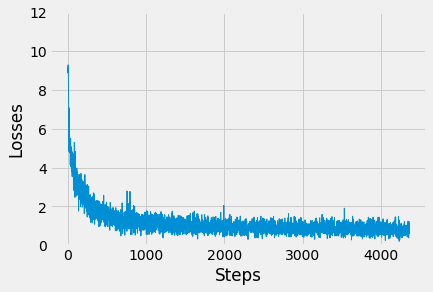

In [32]:
# plot losses

with plt.style.context('fivethirtyeight'):
    plt.plot(losses, linewidth = 1)
    plt.xlabel('Steps')
    plt.ylabel('Losses')
    plt.ylim((0, 12))

plt.show()

In [33]:
# let's test the model

with tf.Graph().as_default():
    
    # placeholders
    encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
    decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

    # output projection
    size = 512
    w_t = tf.get_variable('proj_w', [es_vocab_size, size], tf.float32)
    b = tf.get_variable('proj_b', [es_vocab_size], tf.float32)
    w = tf.transpose(w_t)
    output_projection = (w, b)
    
    # change the model so that output at time t can be fed as input at time t+1
    outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                                encoder_inputs,
                                                decoder_inputs,
                                                tf.contrib.rnn.BasicLSTMCell(size),
                                                num_encoder_symbols = en_vocab_size,
                                                num_decoder_symbols = es_vocab_size,
                                                embedding_size = 100,
                                                feed_previous = True, # <-----this is changed----->
                                                output_projection = output_projection,
                                                dtype = tf.float32)
    
    # ops for projecting outputs
    outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

    # let's translate these sentences     
    en_sentences = ['Cameron is expected to give a speech setting out the government’s future strategy',
                    
                   'What we ought to be doing is to get behind the Muslim communities',
                    
                   'Cameron is due to use a speech to warn young Britons tempted to join IS fighters',
                    
                   'The prime minister warned of the dangers posed by those who quietly condone IS militants extremist ideology',
                    
                   'There are two kinds of damages', 
                   'The first is compensatory meaning money to pay for the actual cost of an injury or loss', 
                    'The second is punitive or exemplary meaning an amount of money that is more than the actual damages',
                    
                   'A deportation has certain consequences regarding the number of years within which a deportee may not legally immigrate',
                    'The UK could decide to back out at any point in the negotiations',
                    'The terms of the Brexit are still unclear',
                    'Brussels is likely to make an example of them to deter other member states from following suit']
    
    en_sentences_encoded = [[en_word2idx.get(word, 0) for word in en_sentence.split()] for en_sentence in en_sentences]
    
    # padding to fit encoder input
    for i in range(len(en_sentences_encoded)):
        en_sentences_encoded[i] += (15 - len(en_sentences_encoded[i])) * [en_word2idx['<pad>']]
    
    # restore all variables - use the last checkpoint saved
    saver = tf.train.Saver()
    path = tf.train.latest_checkpoint('checkpoints')
    
    with tf.Session() as sess:
        # restore
        saver.restore(sess, path)
        
        # feed data into placeholders
        feed = {}
        for i in range(input_seq_len):
            feed[encoder_inputs[i].name] = np.array([en_sentences_encoded[j][i] for j in range(len(en_sentences_encoded))], dtype = np.int32)
            
        feed[decoder_inputs[0].name] = np.array([es_word2idx['<go>']] * len(en_sentences_encoded), dtype = np.int32)
        
        # translate
        output_sequences = sess.run(outputs_proj, feed_dict = feed)
        
        # decode seq.
        for i in range(len(en_sentences_encoded)):
            print ('{}.\n--------------------------------'.format(i+1))
            ouput_seq = [output_sequences[j][i] for j in range(output_seq_len)]
            #decode output sequence
            words = decode_output(ouput_seq)
        
            print (en_sentences[i], end = '\n', )
            for i in range(len(words)):
                if words[i] not in ['<eos>', '<pad>', '<go>']:
                    print (words[i], end = ' ')
            
            print ('\n--------------------------------')

INFO:tensorflow:Restoring parameters from checkpoints/-21759
1.
--------------------------------
Cameron is expected to give a speech setting out the government’s future strategy
Se ha sido un discurso que ha debate de un futuro 
--------------------------------
2.
--------------------------------
What we ought to be doing is to get behind the Muslim communities
¿Qué es que escuchar que era que era las personas 
--------------------------------
3.
--------------------------------
Cameron is due to use a speech to warn young Britons tempted to join IS fighters
Se ha sido utilizar un discurso para utilizar a la <ukn> para <ukn> <ukn> <ukn> <ukn> <ukn> 
--------------------------------
4.
--------------------------------
The prime minister warned of the dangers posed by those who quietly condone IS militants extremist ideology
El Ministro El Ministro del peligros del peligros de que <ukn> en un poco <ukn> 
--------------------------------
5.
--------------------------------
There are two 

#### BLEU index calculatios

In [34]:
import nltk

hypothesis1 = 'La gestión pública tiene que dar un discurso para la estrategia futura'.split()
hypothesis2 = 'Lo que tenemos que hacer es que sea el problema de las comunidades comunitarias'.split()
hypothesis3 = 'El europeo está emplear utilizar un discurso para el <ukn> de <ukn> <ukn> <ukn>'.split()
hypothesis4 = 'El Ministro del Sr Evans ha dicho que por los que se ha hecho'.split()
hypothesis5 = 'Hay dos tipos de crédito'.split()
hypothesis6 = 'El primero es el dinero del dinero para pagar el coste de un beneficio'.split()
hypothesis7 = 'El segundo es que es un cierto papel de dinero que es un cierto dinero'.split()
hypothesis8 = 'Una condición que se ha hecho algunas consecuencias sobre años dentro de un posible plazo'.split()
hypothesis__ = 'La decisión podría decidir decidir a la cuestión en las negociaciones'.split()
hypothesis9  = 'Los términos del <ukn> están todavía claro'.split()
hypothesis10 = 'Bruselas se puede realizar por ejemplo en su corazón otros Estados miembro de otros Estados'.split()

reference1 = 'Se espera que Cameron pronuncie un discurso exponiendo la estrategia futura del gobierno'.split()
reference2 = 'Lo que deberíamos hacer es apoyar a las comunidades musulmanas'.split()
reference3 = "Cameron tiene programado un discurso para advertir a los jóvenes británicos tentados a unirse con los combatientes del Estado Islámico".split()
reference4 = 'El primer ministro advirtió sobre los peligros que plantean aquellos que calladamente toleran la ideología extremista de los militantes del EI'.split()                
reference5 = 'Hay dos tipos de daños'.split()
reference6 = 'El primero es el dinero compensatorio que significa dinero para pagar el costo real de una lesión o pérdida'.split()
reference7 = "El segundo es punitivo o ejemplar que significa cantidad de dinero mayor que los daños reales".split()
reference8 = 'Una deportación tiene ciertas consecuencias con respecto a la cantidad de años durante los cuales un deportado no puede inmigrar legalmente'.split()
reference9 = 'Los términos del Brexit aún no están claros'.split()
reference10 = 'Es probable que Bruselas haga un ejemplo de ellos para disuadir a otros Estados miembros de seguir su ejemplo'.split()

bleuScores = []
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference1], hypothesis1)
bleuScores.append(BLEUscore)
print (BLEUscore)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference2], hypothesis2)
bleuScores.append(BLEUscore)
print (BLEUscore)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference3], hypothesis3)
bleuScores.append(BLEUscore)
print (BLEUscore)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference4], hypothesis4)
bleuScores.append(BLEUscore)
print (BLEUscore)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference5], hypothesis5)
bleuScores.append(BLEUscore)
print (BLEUscore)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference6], hypothesis6)
bleuScores.append(BLEUscore)
print (BLEUscore)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference7], hypothesis7)
bleuScores.append(BLEUscore)
print (BLEUscore)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference8], hypothesis8)
bleuScores.append(BLEUscore)
print (BLEUscore)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference9], hypothesis9)
bleuScores.append(BLEUscore)
print (BLEUscore)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference10], hypothesis10)
bleuScores.append(BLEUscore)
print (BLEUscore)

0.3144006510201675
0.5607900239988007
0.14914147968282956
0.46888166570791445
0.668740304976422
0.31991221505676887
0.27705194057255156
0.5093330917854971
0.38297956737438044
0.3148988880384631


/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [35]:
print (bleuScores)

[0.3144006510201675, 0.5607900239988007, 0.14914147968282956, 0.46888166570791445, 0.668740304976422, 0.31991221505676887, 0.27705194057255156, 0.5093330917854971, 0.38297956737438044, 0.3148988880384631]


In [36]:
import numpy as np
print ("average BLEU score is: ", np.mean(bleuScores))

average BLEU score is:  0.396612982821


# The average BLEU score is 0.396612982821
We used on 2 millions sentences from parlamet parallel corpus